<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_INDIAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1



DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"
DATA_SONG_DIR = "originals"
DATA_IMG_DIR = "originals"
input_bins = 48
BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/"



seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
train_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      train_files.append([file,file, "Western_numpy"])
    else:
      print(file)



for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Indian_numpy")):
  for file in fileList:
    if(True):
      train_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

train_data = pd.DataFrame(train_files, columns=['Images','songs','labels'])
train_data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/Western_numpy


,Images,songs,labels
0,western_011918_mel_1.npy,western_011918_mel_1.npy,Western_numpy
1,western_017500_mel_0.npy,western_017500_mel_0.npy,Western_numpy
2,western_001701_mel_0.npy,western_001701_mel_0.npy,Western_numpy
3,western_011242_mel_1.npy,western_011242_mel_1.npy,Western_numpy
4,western_012387_mel_0.npy,western_012387_mel_0.npy,Western_numpy


In [5]:
test_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      test_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
test_files = random.sample(test_files, len(test_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Indian_numpy")):
  for file in fileList:
    if(True):
      test_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

test_data = pd.DataFrame(test_files, columns=['Images','songs','labels'])
test_data.head()

,Images,songs,labels
0,western_003707_mel_1.npy,western_003707_mel_1.npy,Western_numpy
1,western_000718_mel_1.npy,western_000718_mel_1.npy,Western_numpy
2,western_000890_mel_1.npy,western_000890_mel_1.npy,Western_numpy
3,western_000667_mel_1.npy,western_000667_mel_1.npy,Western_numpy
4,western_003895_mel_1.npy,western_003895_mel_1.npy,Western_numpy


In [6]:
train_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2811,2811
Western_numpy,1400,1400


In [7]:
test_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,1205,1205
Western_numpy,600,600


/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/test/Western_numpy/western_017132_mel_1.npy
61.37639


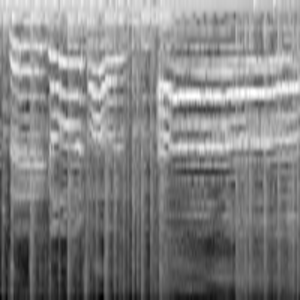

In [8]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR,"test", test_data.loc[test_idx, 'labels'], test_data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



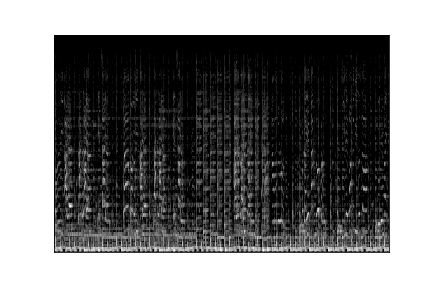

In [9]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [10]:
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])
train_data.head()

,Images,songs,labels,encoded_labels
0,western_011918_mel_1.npy,western_011918_mel_1.npy,Western_numpy,1
1,western_017500_mel_0.npy,western_017500_mel_0.npy,Western_numpy,1
2,western_001701_mel_0.npy,western_001701_mel_0.npy,Western_numpy,1
3,western_011242_mel_1.npy,western_011242_mel_1.npy,Western_numpy,1
4,western_012387_mel_0.npy,western_012387_mel_0.npy,Western_numpy,1


In [11]:
test_data['encoded_labels'] = lb.transform(test_data['labels'])
test_data.head()

,Images,songs,labels,encoded_labels
0,western_003707_mel_1.npy,western_003707_mel_1.npy,Western_numpy,1
1,western_000718_mel_1.npy,western_000718_mel_1.npy,Western_numpy,1
2,western_000890_mel_1.npy,western_000890_mel_1.npy,Western_numpy,1
3,western_000667_mel_1.npy,western_000667_mel_1.npy,Western_numpy,1
4,western_003895_mel_1.npy,western_003895_mel_1.npy,Western_numpy,1


In [12]:
classes = ('Indian_numpy', 'Western_numpy')
train_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,1400,1400


In [13]:
test_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,600,600


In [14]:
from sklearn.model_selection import train_test_split

train_data_combined = train_data.copy(deep=True)
test_data_combined = test_data.copy(deep=True)

train_data = train_data[train_data['labels'] == "Indian_numpy"]
test_data = test_data[test_data['labels'] == "Indian_numpy"]


#df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = train_data.reset_index(drop=True)
df_test = test_data.reset_index(drop=True)


In [15]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811


In [16]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205


In [17]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [18]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [19]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

train_dataset_combined = MEL_Dataset(train_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset_combined = MEL_Dataset(test_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

In [20]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

trainloader_combined = torch.utils.data.DataLoader(train_dataset_combined, batch_size=batch_size)
testloader_combined = torch.utils.data.DataLoader(test_dataset_combined, batch_size=batch_size)

In [21]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

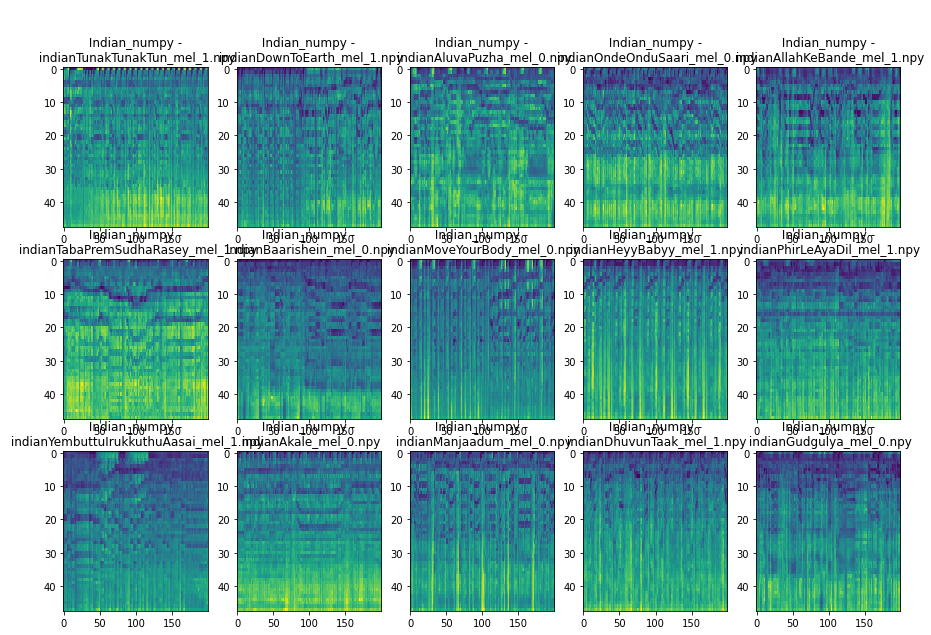

In [22]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

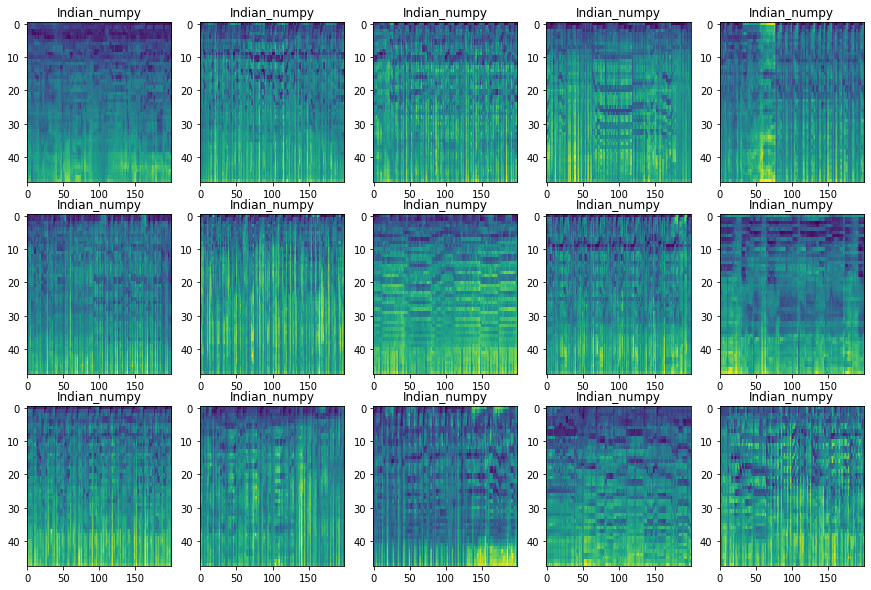

In [23]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [24]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [25]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1154.249
[1,     2] loss: 1135.540
[1,     3] loss: 1074.489
[1,     4] loss: 908.662
[1,     5] loss: 912.330
[1,     6] loss: 700.268
[1,     7] loss: 514.037
[1,     8] loss: 251.919
[1,     9] loss: 158.343
[1,    10] loss: 367.741
[1,    11] loss: 197.437
[1,    12] loss: 93.917
[1,    13] loss: 88.377
[1,    14] loss: 105.106
[1,    15] loss: 142.065
[1,    16] loss: 141.661
[1,    17] loss: 134.783
[1,    18] loss: 120.702
[1,    19] loss: 112.257
[1,    20] loss: 91.205
[1,    21] loss: 92.857
[1,    22] loss: 96.391
[1,    23] loss: 102.412
[1,    24] loss: 98.619
[1,    25] loss: 102.065
[1,    26] loss: 117.116
[1,    27] loss: 92.946
[1,    28] loss: 78.110
[1,    29] loss: 76.983
[1,    30] loss: 75.803
[1,    31] loss: 85.441
[1,    32] loss: 88.557
[1,    33] loss: 91.553
[1,    34] loss: 78.138
[1,    35] loss: 80.923
[1,    36] loss: 84.283
[1,    37] loss: 87.676
[1,    38] loss: 74.184
[1,    39] loss: 78.774
[1,    40] loss: 72.376
[1,    41] loss: 

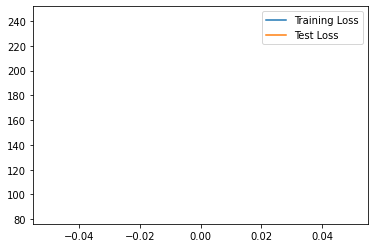

[2,     1] loss: 73.396
[2,     2] loss: 75.453
[2,     3] loss: 78.831
[2,     4] loss: 68.461
[2,     5] loss: 79.762
[2,     6] loss: 79.235
[2,     7] loss: 89.786
[2,     8] loss: 84.596
[2,     9] loss: 79.763
[2,    10] loss: 68.270
[2,    11] loss: 66.220
[2,    12] loss: 77.650
[2,    13] loss: 74.681
[2,    14] loss: 71.890
[2,    15] loss: 73.782
[2,    16] loss: 66.579
[2,    17] loss: 74.829
[2,    18] loss: 71.444
[2,    19] loss: 77.784
[2,    20] loss: 68.680
[2,    21] loss: 76.455
[2,    22] loss: 84.015
[2,    23] loss: 83.997
[2,    24] loss: 73.121
[2,    25] loss: 71.068
[2,    26] loss: 80.649
[2,    27] loss: 71.786
[2,    28] loss: 66.133
[2,    29] loss: 72.163
[2,    30] loss: 73.298
[2,    31] loss: 81.073
[2,    32] loss: 75.755
[2,    33] loss: 80.475
[2,    34] loss: 71.815
[2,    35] loss: 73.964
[2,    36] loss: 77.700
[2,    37] loss: 82.886
[2,    38] loss: 71.128
[2,    39] loss: 75.687
[2,    40] loss: 70.350
[2,    41] loss: 71.051
[2,    42] loss:

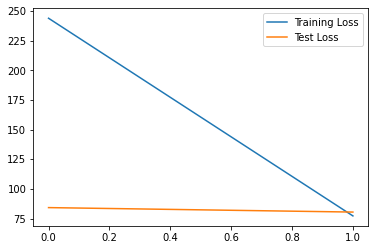

[3,     1] loss: 69.250
[3,     2] loss: 73.173
[3,     3] loss: 77.494
[3,     4] loss: 68.141
[3,     5] loss: 76.622
[3,     6] loss: 76.588
[3,     7] loss: 85.559
[3,     8] loss: 81.030
[3,     9] loss: 76.984
[3,    10] loss: 68.412
[3,    11] loss: 65.863
[3,    12] loss: 76.370
[3,    13] loss: 73.500
[3,    14] loss: 69.797
[3,    15] loss: 72.265
[3,    16] loss: 65.605
[3,    17] loss: 72.118
[3,    18] loss: 69.727
[3,    19] loss: 76.168
[3,    20] loss: 67.539
[3,    21] loss: 74.702
[3,    22] loss: 81.955
[3,    23] loss: 80.669
[3,    24] loss: 70.098
[3,    25] loss: 69.530
[3,    26] loss: 79.168
[3,    27] loss: 71.119
[3,    28] loss: 65.059
[3,    29] loss: 69.604
[3,    30] loss: 70.863
[3,    31] loss: 79.307
[3,    32] loss: 76.371
[3,    33] loss: 78.190
[3,    34] loss: 69.730
[3,    35] loss: 72.012
[3,    36] loss: 75.712
[3,    37] loss: 79.078
[3,    38] loss: 68.710
[3,    39] loss: 72.336
[3,    40] loss: 69.086
[3,    41] loss: 68.663
[3,    42] loss:

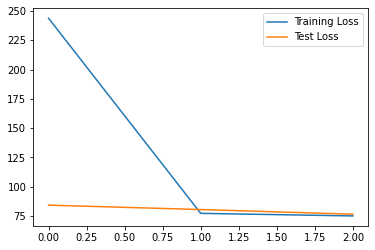

[4,     1] loss: 67.135
[4,     2] loss: 69.527
[4,     3] loss: 72.610
[4,     4] loss: 62.326
[4,     5] loss: 73.010
[4,     6] loss: 72.102
[4,     7] loss: 76.110
[4,     8] loss: 73.680
[4,     9] loss: 67.444
[4,    10] loss: 63.979
[4,    11] loss: 60.333
[4,    12] loss: 67.626
[4,    13] loss: 68.979
[4,    14] loss: 63.821
[4,    15] loss: 67.806
[4,    16] loss: 59.669
[4,    17] loss: 65.763
[4,    18] loss: 60.527
[4,    19] loss: 68.625
[4,    20] loss: 61.637
[4,    21] loss: 64.121
[4,    22] loss: 69.543
[4,    23] loss: 66.290
[4,    24] loss: 60.993
[4,    25] loss: 62.586
[4,    26] loss: 61.702
[4,    27] loss: 62.737
[4,    28] loss: 57.349
[4,    29] loss: 58.906
[4,    30] loss: 59.328
[4,    31] loss: 65.435
[4,    32] loss: 65.653
[4,    33] loss: 66.830
[4,    34] loss: 58.107
[4,    35] loss: 60.392
[4,    36] loss: 65.684
[4,    37] loss: 63.102
[4,    38] loss: 61.350
[4,    39] loss: 61.906
[4,    40] loss: 62.879
[4,    41] loss: 60.791
[4,    42] loss:

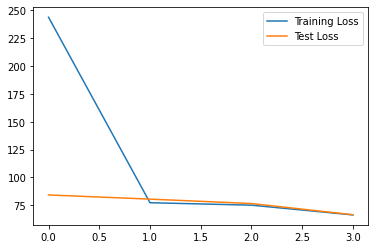

[5,     1] loss: 57.774
[5,     2] loss: 64.998
[5,     3] loss: 62.547
[5,     4] loss: 57.179
[5,     5] loss: 62.332
[5,     6] loss: 67.311
[5,     7] loss: 66.480
[5,     8] loss: 63.288
[5,     9] loss: 61.123
[5,    10] loss: 60.253
[5,    11] loss: 54.799
[5,    12] loss: 63.591
[5,    13] loss: 63.483
[5,    14] loss: 61.078
[5,    15] loss: 61.537
[5,    16] loss: 57.856
[5,    17] loss: 62.044
[5,    18] loss: 57.279
[5,    19] loss: 64.691
[5,    20] loss: 60.042
[5,    21] loss: 62.811
[5,    22] loss: 66.728
[5,    23] loss: 64.736
[5,    24] loss: 60.289
[5,    25] loss: 61.373
[5,    26] loss: 60.706
[5,    27] loss: 61.986
[5,    28] loss: 56.834
[5,    29] loss: 58.253
[5,    30] loss: 58.878
[5,    31] loss: 64.609
[5,    32] loss: 64.443
[5,    33] loss: 65.767
[5,    34] loss: 57.734
[5,    35] loss: 59.999
[5,    36] loss: 64.748
[5,    37] loss: 62.575
[5,    38] loss: 60.557
[5,    39] loss: 61.125
[5,    40] loss: 62.332
[5,    41] loss: 59.530
[5,    42] loss:

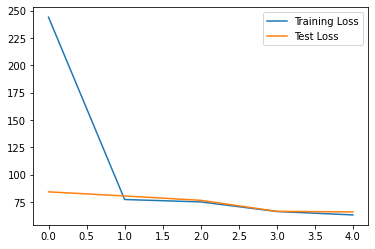

[6,     1] loss: 57.357
[6,     2] loss: 64.045
[6,     3] loss: 62.058
[6,     4] loss: 55.710
[6,     5] loss: 62.128
[6,     6] loss: 66.063
[6,     7] loss: 66.056
[6,     8] loss: 62.732
[6,     9] loss: 60.455
[6,    10] loss: 60.076
[6,    11] loss: 54.569
[6,    12] loss: 63.304
[6,    13] loss: 63.168
[6,    14] loss: 61.012
[6,    15] loss: 61.037
[6,    16] loss: 57.928
[6,    17] loss: 61.758
[6,    18] loss: 57.098
[6,    19] loss: 64.644
[6,    20] loss: 59.756
[6,    21] loss: 62.827
[6,    22] loss: 66.386
[6,    23] loss: 64.702
[6,    24] loss: 60.184
[6,    25] loss: 61.089
[6,    26] loss: 60.688
[6,    27] loss: 61.875
[6,    28] loss: 56.708
[6,    29] loss: 58.190
[6,    30] loss: 58.730
[6,    31] loss: 64.345
[6,    32] loss: 64.281
[6,    33] loss: 65.528
[6,    34] loss: 57.643
[6,    35] loss: 59.797
[6,    36] loss: 64.511
[6,    37] loss: 62.191
[6,    38] loss: 60.387
[6,    39] loss: 60.906
[6,    40] loss: 62.163
[6,    41] loss: 59.410
[6,    42] loss:

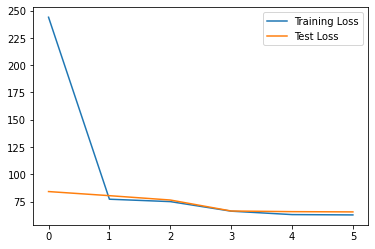

[7,     1] loss: 57.226
[7,     2] loss: 63.740
[7,     3] loss: 61.874
[7,     4] loss: 55.431
[7,     5] loss: 61.929
[7,     6] loss: 65.785
[7,     7] loss: 65.748
[7,     8] loss: 62.668
[7,     9] loss: 60.146
[7,    10] loss: 59.986
[7,    11] loss: 54.525
[7,    12] loss: 63.115
[7,    13] loss: 63.019
[7,    14] loss: 60.972
[7,    15] loss: 60.834
[7,    16] loss: 57.902
[7,    17] loss: 61.772
[7,    18] loss: 56.951
[7,    19] loss: 64.611
[7,    20] loss: 59.516
[7,    21] loss: 62.698
[7,    22] loss: 66.117
[7,    23] loss: 64.334
[7,    24] loss: 59.953
[7,    25] loss: 60.829
[7,    26] loss: 60.434
[7,    27] loss: 61.777
[7,    28] loss: 56.515
[7,    29] loss: 58.092
[7,    30] loss: 58.568
[7,    31] loss: 63.833
[7,    32] loss: 64.083
[7,    33] loss: 65.155
[7,    34] loss: 57.466
[7,    35] loss: 59.588
[7,    36] loss: 64.212
[7,    37] loss: 61.746
[7,    38] loss: 60.182
[7,    39] loss: 60.682
[7,    40] loss: 61.971
[7,    41] loss: 59.375
[7,    42] loss:

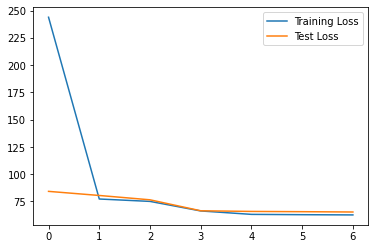

[8,     1] loss: 57.083
[8,     2] loss: 63.386
[8,     3] loss: 61.634
[8,     4] loss: 55.129
[8,     5] loss: 61.679
[8,     6] loss: 65.429
[8,     7] loss: 65.417
[8,     8] loss: 62.571
[8,     9] loss: 59.708
[8,    10] loss: 59.882
[8,    11] loss: 54.369
[8,    12] loss: 62.825
[8,    13] loss: 62.808
[8,    14] loss: 60.726
[8,    15] loss: 60.560
[8,    16] loss: 57.734
[8,    17] loss: 61.600
[8,    18] loss: 56.766
[8,    19] loss: 64.292
[8,    20] loss: 59.122
[8,    21] loss: 62.418
[8,    22] loss: 65.488
[8,    23] loss: 63.887
[8,    24] loss: 59.425
[8,    25] loss: 60.337
[8,    26] loss: 60.139
[8,    27] loss: 61.485
[8,    28] loss: 56.244
[8,    29] loss: 57.917
[8,    30] loss: 58.314
[8,    31] loss: 63.086
[8,    32] loss: 63.648
[8,    33] loss: 64.595
[8,    34] loss: 57.215
[8,    35] loss: 59.228
[8,    36] loss: 63.683
[8,    37] loss: 60.987
[8,    38] loss: 59.748
[8,    39] loss: 60.235
[8,    40] loss: 61.593
[8,    41] loss: 59.104
[8,    42] loss:

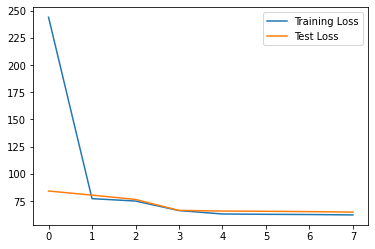

[9,     1] loss: 56.887
[9,     2] loss: 62.726
[9,     3] loss: 61.097
[9,     4] loss: 54.694
[9,     5] loss: 61.158
[9,     6] loss: 64.810
[9,     7] loss: 64.889
[9,     8] loss: 62.293
[9,     9] loss: 59.011
[9,    10] loss: 59.684
[9,    11] loss: 53.952
[9,    12] loss: 62.340
[9,    13] loss: 62.326
[9,    14] loss: 60.127
[9,    15] loss: 60.107
[9,    16] loss: 57.248
[9,    17] loss: 61.274
[9,    18] loss: 56.406
[9,    19] loss: 63.605
[9,    20] loss: 58.467
[9,    21] loss: 61.839
[9,    22] loss: 64.371
[9,    23] loss: 63.092
[9,    24] loss: 58.547
[9,    25] loss: 59.450
[9,    26] loss: 59.604
[9,    27] loss: 60.908
[9,    28] loss: 55.776
[9,    29] loss: 57.543
[9,    30] loss: 57.843
[9,    31] loss: 61.878
[9,    32] loss: 62.884
[9,    33] loss: 63.598
[9,    34] loss: 56.811
[9,    35] loss: 58.707
[9,    36] loss: 62.780
[9,    37] loss: 59.876
[9,    38] loss: 59.104
[9,    39] loss: 59.557
[9,    40] loss: 60.809
[9,    41] loss: 58.552
[9,    42] loss:

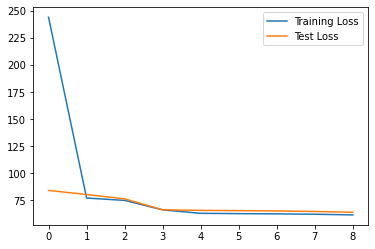

[10,     1] loss: 56.485
[10,     2] loss: 61.771
[10,     3] loss: 60.374
[10,     4] loss: 54.130
[10,     5] loss: 60.422
[10,     6] loss: 63.711
[10,     7] loss: 64.003
[10,     8] loss: 61.895
[10,     9] loss: 58.214
[10,    10] loss: 59.219
[10,    11] loss: 53.271
[10,    12] loss: 61.522
[10,    13] loss: 61.389
[10,    14] loss: 59.173
[10,    15] loss: 59.228
[10,    16] loss: 56.435
[10,    17] loss: 60.753
[10,    18] loss: 55.568
[10,    19] loss: 62.494
[10,    20] loss: 57.406
[10,    21] loss: 60.908
[10,    22] loss: 62.893
[10,    23] loss: 61.754
[10,    24] loss: 57.278
[10,    25] loss: 58.058
[10,    26] loss: 58.521
[10,    27] loss: 59.825
[10,    28] loss: 54.820
[10,    29] loss: 56.641
[10,    30] loss: 56.843
[10,    31] loss: 59.842
[10,    32] loss: 61.635
[10,    33] loss: 62.142
[10,    34] loss: 55.970
[10,    35] loss: 57.796
[10,    36] loss: 61.660
[10,    37] loss: 58.531
[10,    38] loss: 58.276
[10,    39] loss: 58.870
[10,    40] loss: 59.168


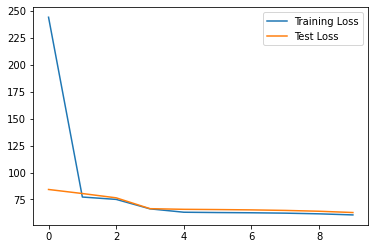

[11,     1] loss: 55.561
[11,     2] loss: 60.177
[11,     3] loss: 59.598
[11,     4] loss: 53.106
[11,     5] loss: 59.550
[11,     6] loss: 61.859
[11,     7] loss: 62.699
[11,     8] loss: 60.924
[11,     9] loss: 57.084
[11,    10] loss: 58.051
[11,    11] loss: 52.325
[11,    12] loss: 60.025
[11,    13] loss: 59.854
[11,    14] loss: 57.556
[11,    15] loss: 57.784
[11,    16] loss: 55.073
[11,    17] loss: 59.288
[11,    18] loss: 53.973
[11,    19] loss: 60.365
[11,    20] loss: 55.986
[11,    21] loss: 59.873
[11,    22] loss: 61.014
[11,    23] loss: 60.462
[11,    24] loss: 55.678
[11,    25] loss: 56.048
[11,    26] loss: 57.317
[11,    27] loss: 58.190
[11,    28] loss: 53.269
[11,    29] loss: 54.982
[11,    30] loss: 55.252
[11,    31] loss: 57.972
[11,    32] loss: 59.818
[11,    33] loss: 60.616
[11,    34] loss: 55.055
[11,    35] loss: 56.177
[11,    36] loss: 58.658
[11,    37] loss: 56.694
[11,    38] loss: 56.607
[11,    39] loss: 56.529
[11,    40] loss: 57.126


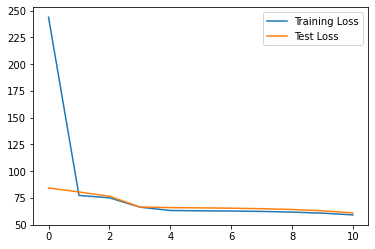

[12,     1] loss: 53.777
[12,     2] loss: 57.954
[12,     3] loss: 57.259
[12,     4] loss: 51.770
[12,     5] loss: 56.754
[12,     6] loss: 59.326
[12,     7] loss: 60.125
[12,     8] loss: 58.278
[12,     9] loss: 55.899
[12,    10] loss: 56.054
[12,    11] loss: 50.507
[12,    12] loss: 58.247
[12,    13] loss: 57.944
[12,    14] loss: 55.478
[12,    15] loss: 55.704
[12,    16] loss: 53.633
[12,    17] loss: 57.036
[12,    18] loss: 51.773
[12,    19] loss: 57.624
[12,    20] loss: 54.414
[12,    21] loss: 58.046
[12,    22] loss: 58.241
[12,    23] loss: 58.116
[12,    24] loss: 54.570
[12,    25] loss: 54.256
[12,    26] loss: 54.838
[12,    27] loss: 56.366
[12,    28] loss: 51.261
[12,    29] loss: 52.858
[12,    30] loss: 53.610
[12,    31] loss: 55.724
[12,    32] loss: 57.611
[12,    33] loss: 57.750
[12,    34] loss: 53.449
[12,    35] loss: 54.191
[12,    36] loss: 55.460
[12,    37] loss: 54.740
[12,    38] loss: 55.092
[12,    39] loss: 54.586
[12,    40] loss: 54.423


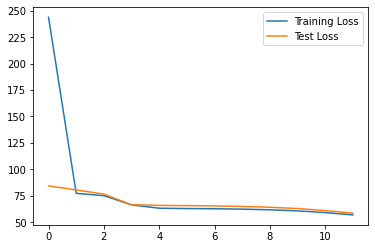

[13,     1] loss: 52.390
[13,     2] loss: 55.496
[13,     3] loss: 54.287
[13,     4] loss: 50.623
[13,     5] loss: 54.400
[13,     6] loss: 55.758
[13,     7] loss: 58.906
[13,     8] loss: 55.226
[13,     9] loss: 55.527
[13,    10] loss: 56.134
[13,    11] loss: 48.562
[13,    12] loss: 57.822
[13,    13] loss: 56.893
[13,    14] loss: 54.165
[13,    15] loss: 54.234
[13,    16] loss: 52.346
[13,    17] loss: 55.678
[13,    18] loss: 49.554
[13,    19] loss: 54.883
[13,    20] loss: 53.200
[13,    21] loss: 55.323
[13,    22] loss: 56.016
[13,    23] loss: 56.123
[13,    24] loss: 52.513
[13,    25] loss: 52.275
[13,    26] loss: 53.408
[13,    27] loss: 54.998
[13,    28] loss: 49.880
[13,    29] loss: 51.270
[13,    30] loss: 51.802
[13,    31] loss: 52.625
[13,    32] loss: 55.592
[13,    33] loss: 55.351
[13,    34] loss: 51.600
[13,    35] loss: 52.429
[13,    36] loss: 52.696
[13,    37] loss: 52.834
[13,    38] loss: 53.086
[13,    39] loss: 52.942
[13,    40] loss: 51.953


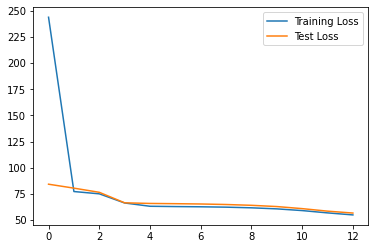

[14,     1] loss: 50.948
[14,     2] loss: 53.584
[14,     3] loss: 52.304
[14,     4] loss: 48.660
[14,     5] loss: 52.531
[14,     6] loss: 52.850
[14,     7] loss: 56.321
[14,     8] loss: 55.079
[14,     9] loss: 53.330
[14,    10] loss: 52.733
[14,    11] loss: 47.806
[14,    12] loss: 54.609
[14,    13] loss: 54.903
[14,    14] loss: 52.835
[14,    15] loss: 52.731
[14,    16] loss: 52.282
[14,    17] loss: 53.963
[14,    18] loss: 48.074
[14,    19] loss: 53.268
[14,    20] loss: 52.381
[14,    21] loss: 55.461
[14,    22] loss: 53.857
[14,    23] loss: 54.453
[14,    24] loss: 51.012
[14,    25] loss: 50.792
[14,    26] loss: 51.610
[14,    27] loss: 53.160
[14,    28] loss: 48.392
[14,    29] loss: 49.783
[14,    30] loss: 50.567
[14,    31] loss: 50.960
[14,    32] loss: 53.687
[14,    33] loss: 54.036
[14,    34] loss: 50.273
[14,    35] loss: 51.345
[14,    36] loss: 50.894
[14,    37] loss: 50.941
[14,    38] loss: 51.641
[14,    39] loss: 51.425
[14,    40] loss: 50.628


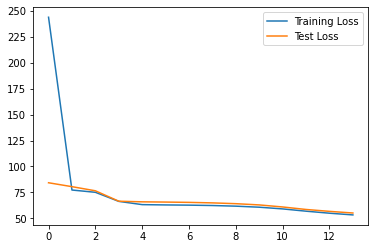

[15,     1] loss: 49.685
[15,     2] loss: 51.856
[15,     3] loss: 50.784
[15,     4] loss: 47.238
[15,     5] loss: 51.095
[15,     6] loss: 51.199
[15,     7] loss: 55.125
[15,     8] loss: 53.847
[15,     9] loss: 51.314
[15,    10] loss: 51.713
[15,    11] loss: 46.365
[15,    12] loss: 53.422
[15,    13] loss: 53.422
[15,    14] loss: 51.316
[15,    15] loss: 51.740
[15,    16] loss: 50.154
[15,    17] loss: 52.593
[15,    18] loss: 46.960
[15,    19] loss: 51.746
[15,    20] loss: 52.105
[15,    21] loss: 53.817
[15,    22] loss: 52.369
[15,    23] loss: 53.269
[15,    24] loss: 49.513
[15,    25] loss: 50.079
[15,    26] loss: 49.675
[15,    27] loss: 51.800
[15,    28] loss: 47.054
[15,    29] loss: 48.838
[15,    30] loss: 49.493
[15,    31] loss: 49.213
[15,    32] loss: 52.436
[15,    33] loss: 52.714
[15,    34] loss: 49.109
[15,    35] loss: 50.482
[15,    36] loss: 49.531
[15,    37] loss: 49.882
[15,    38] loss: 50.323
[15,    39] loss: 50.312
[15,    40] loss: 49.678


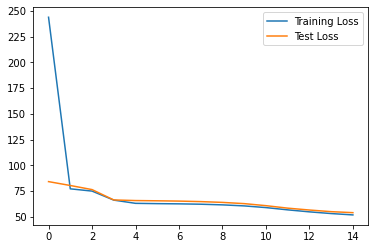

[16,     1] loss: 48.791
[16,     2] loss: 50.571
[16,     3] loss: 50.092
[16,     4] loss: 45.953
[16,     5] loss: 50.056
[16,     6] loss: 49.995
[16,     7] loss: 53.680
[16,     8] loss: 52.102
[16,     9] loss: 49.816
[16,    10] loss: 50.633
[16,    11] loss: 45.060
[16,    12] loss: 52.283
[16,    13] loss: 51.361
[16,    14] loss: 50.196
[16,    15] loss: 50.031
[16,    16] loss: 48.575
[16,    17] loss: 51.637
[16,    18] loss: 45.602
[16,    19] loss: 50.904
[16,    20] loss: 50.378
[16,    21] loss: 51.212
[16,    22] loss: 51.423
[16,    23] loss: 51.451
[16,    24] loss: 48.858
[16,    25] loss: 49.113
[16,    26] loss: 48.360
[16,    27] loss: 50.643
[16,    28] loss: 45.896
[16,    29] loss: 47.976
[16,    30] loss: 48.492
[16,    31] loss: 47.874
[16,    32] loss: 51.392
[16,    33] loss: 51.220
[16,    34] loss: 48.627
[16,    35] loss: 49.379
[16,    36] loss: 48.825
[16,    37] loss: 48.867
[16,    38] loss: 49.298
[16,    39] loss: 49.471
[16,    40] loss: 48.580


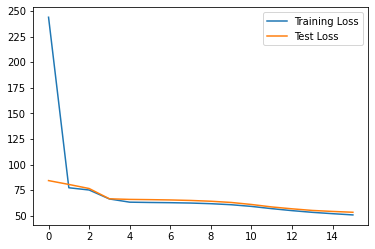

[17,     1] loss: 47.981
[17,     2] loss: 49.697
[17,     3] loss: 49.091
[17,     4] loss: 45.136
[17,     5] loss: 48.785
[17,     6] loss: 49.127
[17,     7] loss: 52.329
[17,     8] loss: 50.436
[17,     9] loss: 48.819
[17,    10] loss: 49.444
[17,    11] loss: 44.141
[17,    12] loss: 51.065
[17,    13] loss: 49.879
[17,    14] loss: 49.308
[17,    15] loss: 48.576
[17,    16] loss: 47.634
[17,    17] loss: 50.445
[17,    18] loss: 44.478
[17,    19] loss: 49.979
[17,    20] loss: 48.710
[17,    21] loss: 50.146
[17,    22] loss: 50.189
[17,    23] loss: 50.288
[17,    24] loss: 47.927
[17,    25] loss: 47.915
[17,    26] loss: 47.298
[17,    27] loss: 49.254
[17,    28] loss: 44.702
[17,    29] loss: 47.062
[17,    30] loss: 47.380
[17,    31] loss: 46.885
[17,    32] loss: 50.128
[17,    33] loss: 50.250
[17,    34] loss: 47.355
[17,    35] loss: 48.366
[17,    36] loss: 47.546
[17,    37] loss: 47.855
[17,    38] loss: 48.272
[17,    39] loss: 48.396
[17,    40] loss: 47.588


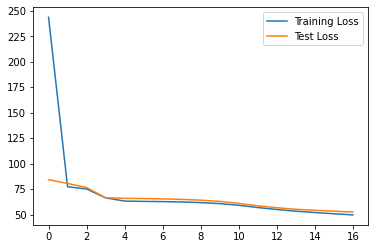

[18,     1] loss: 46.938
[18,     2] loss: 48.676
[18,     3] loss: 48.337
[18,     4] loss: 44.194
[18,     5] loss: 48.106
[18,     6] loss: 48.094
[18,     7] loss: 51.202
[18,     8] loss: 49.697
[18,     9] loss: 48.045
[18,    10] loss: 48.712
[18,    11] loss: 43.424
[18,    12] loss: 50.250
[18,    13] loss: 48.968
[18,    14] loss: 48.394
[18,    15] loss: 47.757
[18,    16] loss: 46.773
[18,    17] loss: 49.422
[18,    18] loss: 43.781
[18,    19] loss: 48.804
[18,    20] loss: 48.051
[18,    21] loss: 49.405
[18,    22] loss: 49.057
[18,    23] loss: 49.245
[18,    24] loss: 46.533
[18,    25] loss: 47.068
[18,    26] loss: 46.321
[18,    27] loss: 48.030
[18,    28] loss: 44.017
[18,    29] loss: 46.057
[18,    30] loss: 46.623
[18,    31] loss: 45.902
[18,    32] loss: 49.052
[18,    33] loss: 49.297
[18,    34] loss: 46.113
[18,    35] loss: 47.525
[18,    36] loss: 46.538
[18,    37] loss: 46.817
[18,    38] loss: 47.441
[18,    39] loss: 47.391
[18,    40] loss: 46.689


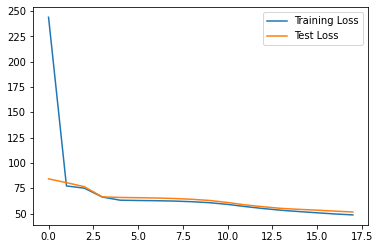

[19,     1] loss: 45.984
[19,     2] loss: 47.756
[19,     3] loss: 47.330
[19,     4] loss: 43.450
[19,     5] loss: 47.556
[19,     6] loss: 47.258
[19,     7] loss: 50.336
[19,     8] loss: 48.869
[19,     9] loss: 47.317
[19,    10] loss: 47.806
[19,    11] loss: 42.734
[19,    12] loss: 49.385
[19,    13] loss: 47.977
[19,    14] loss: 47.701
[19,    15] loss: 46.765
[19,    16] loss: 45.825
[19,    17] loss: 48.437
[19,    18] loss: 42.944
[19,    19] loss: 48.078
[19,    20] loss: 47.011
[19,    21] loss: 48.462
[19,    22] loss: 48.053
[19,    23] loss: 48.457
[19,    24] loss: 45.973
[19,    25] loss: 46.153
[19,    26] loss: 45.672
[19,    27] loss: 47.328
[19,    28] loss: 43.182
[19,    29] loss: 45.501
[19,    30] loss: 45.787
[19,    31] loss: 45.095
[19,    32] loss: 48.246
[19,    33] loss: 48.392
[19,    34] loss: 45.554
[19,    35] loss: 46.761
[19,    36] loss: 46.063
[19,    37] loss: 46.071
[19,    38] loss: 46.954
[19,    39] loss: 46.801
[19,    40] loss: 46.053


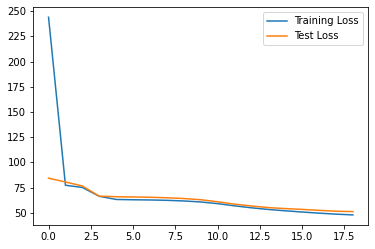

[20,     1] loss: 45.435
[20,     2] loss: 47.021
[20,     3] loss: 46.624
[20,     4] loss: 42.997
[20,     5] loss: 46.533
[20,     6] loss: 46.787
[20,     7] loss: 49.044
[20,     8] loss: 47.866
[20,     9] loss: 46.701
[20,    10] loss: 47.175
[20,    11] loss: 42.136
[20,    12] loss: 48.816
[20,    13] loss: 47.192
[20,    14] loss: 47.082
[20,    15] loss: 45.864
[20,    16] loss: 45.340
[20,    17] loss: 47.659
[20,    18] loss: 42.276
[20,    19] loss: 47.432
[20,    20] loss: 46.330
[20,    21] loss: 47.710
[20,    22] loss: 47.299
[20,    23] loss: 47.582
[20,    24] loss: 44.990
[20,    25] loss: 45.335
[20,    26] loss: 44.906
[20,    27] loss: 46.397
[20,    28] loss: 42.486
[20,    29] loss: 44.787
[20,    30] loss: 44.969
[20,    31] loss: 44.396
[20,    32] loss: 47.359
[20,    33] loss: 47.493
[20,    34] loss: 44.771
[20,    35] loss: 46.137
[20,    36] loss: 45.430
[20,    37] loss: 45.285
[20,    38] loss: 46.637
[20,    39] loss: 45.752
[20,    40] loss: 45.908


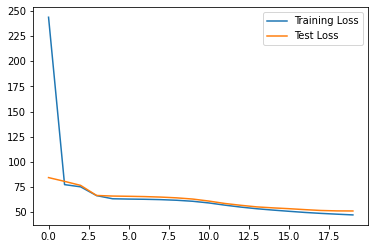

[21,     1] loss: 45.187
[21,     2] loss: 46.385
[21,     3] loss: 46.057
[21,     4] loss: 42.017
[21,     5] loss: 45.980
[21,     6] loss: 45.768
[21,     7] loss: 48.329
[21,     8] loss: 47.048
[21,     9] loss: 46.166
[21,    10] loss: 46.171
[21,    11] loss: 41.592
[21,    12] loss: 47.853
[21,    13] loss: 46.450
[21,    14] loss: 46.205
[21,    15] loss: 45.163
[21,    16] loss: 44.369
[21,    17] loss: 46.749
[21,    18] loss: 41.493
[21,    19] loss: 46.828
[21,    20] loss: 45.305
[21,    21] loss: 47.056
[21,    22] loss: 46.504
[21,    23] loss: 47.166
[21,    24] loss: 44.219
[21,    25] loss: 44.793
[21,    26] loss: 44.077
[21,    27] loss: 45.547
[21,    28] loss: 41.913
[21,    29] loss: 44.045
[21,    30] loss: 44.248
[21,    31] loss: 43.603
[21,    32] loss: 46.507
[21,    33] loss: 46.467
[21,    34] loss: 43.951
[21,    35] loss: 45.489
[21,    36] loss: 44.338
[21,    37] loss: 44.551
[21,    38] loss: 45.481
[21,    39] loss: 44.902
[21,    40] loss: 44.753


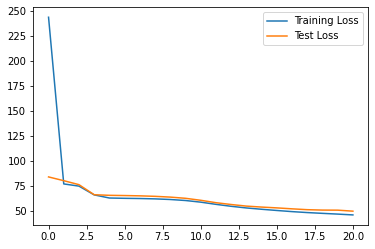

[22,     1] loss: 44.086
[22,     2] loss: 45.534
[22,     3] loss: 44.977
[22,     4] loss: 41.236
[22,     5] loss: 45.133
[22,     6] loss: 44.886
[22,     7] loss: 47.431
[22,     8] loss: 45.924
[22,     9] loss: 45.559
[22,    10] loss: 45.504
[22,    11] loss: 41.135
[22,    12] loss: 47.119
[22,    13] loss: 45.739
[22,    14] loss: 45.709
[22,    15] loss: 44.352
[22,    16] loss: 43.807
[22,    17] loss: 45.983
[22,    18] loss: 40.929
[22,    19] loss: 45.931
[22,    20] loss: 44.609
[22,    21] loss: 46.296
[22,    22] loss: 45.792
[22,    23] loss: 46.079
[22,    24] loss: 43.638
[22,    25] loss: 43.768
[22,    26] loss: 43.510
[22,    27] loss: 44.537
[22,    28] loss: 41.451
[22,    29] loss: 43.363
[22,    30] loss: 43.601
[22,    31] loss: 42.811
[22,    32] loss: 45.759
[22,    33] loss: 45.560
[22,    34] loss: 43.022
[22,    35] loss: 44.790
[22,    36] loss: 43.619
[22,    37] loss: 43.889
[22,    38] loss: 44.842
[22,    39] loss: 44.202
[22,    40] loss: 44.274


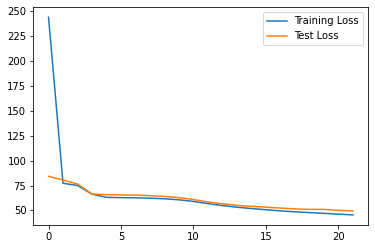

[23,     1] loss: 43.495
[23,     2] loss: 44.881
[23,     3] loss: 44.238
[23,     4] loss: 40.650
[23,     5] loss: 44.491
[23,     6] loss: 44.163
[23,     7] loss: 46.953
[23,     8] loss: 45.077
[23,     9] loss: 44.934
[23,    10] loss: 44.679
[23,    11] loss: 40.819
[23,    12] loss: 46.493
[23,    13] loss: 44.860
[23,    14] loss: 45.051
[23,    15] loss: 43.861
[23,    16] loss: 43.126
[23,    17] loss: 45.016
[23,    18] loss: 40.266
[23,    19] loss: 45.313
[23,    20] loss: 43.601
[23,    21] loss: 45.396
[23,    22] loss: 44.839
[23,    23] loss: 45.465
[23,    24] loss: 42.892
[23,    25] loss: 43.238
[23,    26] loss: 42.764
[23,    27] loss: 43.876
[23,    28] loss: 40.575
[23,    29] loss: 42.528
[23,    30] loss: 42.866
[23,    31] loss: 42.002
[23,    32] loss: 44.903
[23,    33] loss: 44.531
[23,    34] loss: 42.341
[23,    35] loss: 44.075
[23,    36] loss: 42.821
[23,    37] loss: 43.054
[23,    38] loss: 43.963
[23,    39] loss: 43.338
[23,    40] loss: 43.193


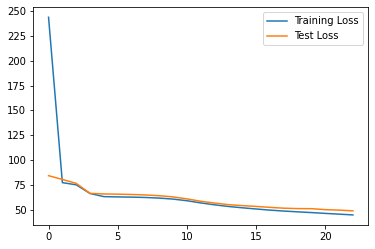

[24,     1] loss: 42.676
[24,     2] loss: 43.970
[24,     3] loss: 43.308
[24,     4] loss: 39.823
[24,     5] loss: 43.561
[24,     6] loss: 43.404
[24,     7] loss: 45.951
[24,     8] loss: 44.216
[24,     9] loss: 43.848
[24,    10] loss: 43.809
[24,    11] loss: 40.236
[24,    12] loss: 45.774
[24,    13] loss: 44.060
[24,    14] loss: 44.121
[24,    15] loss: 43.138
[24,    16] loss: 42.490
[24,    17] loss: 44.161
[24,    18] loss: 39.584
[24,    19] loss: 44.433
[24,    20] loss: 42.876
[24,    21] loss: 44.500
[24,    22] loss: 43.899
[24,    23] loss: 44.416
[24,    24] loss: 42.232
[24,    25] loss: 42.538
[24,    26] loss: 42.226
[24,    27] loss: 43.261
[24,    28] loss: 39.821
[24,    29] loss: 41.823
[24,    30] loss: 42.297
[24,    31] loss: 41.341
[24,    32] loss: 44.200
[24,    33] loss: 43.648
[24,    34] loss: 41.678
[24,    35] loss: 43.488
[24,    36] loss: 42.160
[24,    37] loss: 42.355
[24,    38] loss: 43.314
[24,    39] loss: 42.542
[24,    40] loss: 42.672


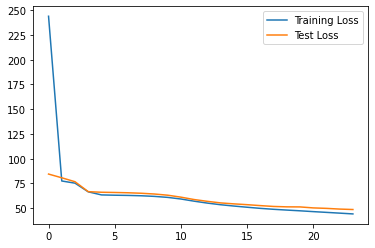

[25,     1] loss: 42.141
[25,     2] loss: 43.283
[25,     3] loss: 42.405
[25,     4] loss: 39.111
[25,     5] loss: 42.753
[25,     6] loss: 42.547
[25,     7] loss: 44.823
[25,     8] loss: 43.140
[25,     9] loss: 43.045
[25,    10] loss: 43.329
[25,    11] loss: 39.427
[25,    12] loss: 44.648
[25,    13] loss: 43.385
[25,    14] loss: 43.409
[25,    15] loss: 42.146
[25,    16] loss: 41.416
[25,    17] loss: 43.647
[25,    18] loss: 39.408
[25,    19] loss: 43.694
[25,    20] loss: 42.038
[25,    21] loss: 44.161
[25,    22] loss: 43.480
[25,    23] loss: 43.933
[25,    24] loss: 41.386
[25,    25] loss: 41.484
[25,    26] loss: 41.042
[25,    27] loss: 42.161
[25,    28] loss: 38.911
[25,    29] loss: 41.079
[25,    30] loss: 41.453
[25,    31] loss: 40.291
[25,    32] loss: 43.264
[25,    33] loss: 42.775
[25,    34] loss: 40.697
[25,    35] loss: 42.446
[25,    36] loss: 41.161
[25,    37] loss: 41.557
[25,    38] loss: 42.351
[25,    39] loss: 41.701
[25,    40] loss: 41.804


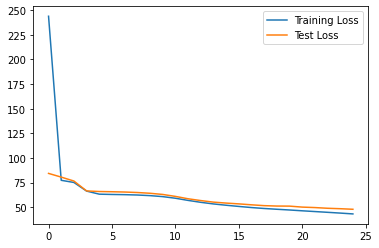

[26,     1] loss: 41.447
[26,     2] loss: 42.430
[26,     3] loss: 41.559
[26,     4] loss: 38.368
[26,     5] loss: 42.030
[26,     6] loss: 41.940
[26,     7] loss: 44.039
[26,     8] loss: 42.424
[26,     9] loss: 42.105
[26,    10] loss: 42.207
[26,    11] loss: 38.597
[26,    12] loss: 43.888
[26,    13] loss: 42.321
[26,    14] loss: 42.442
[26,    15] loss: 41.294
[26,    16] loss: 40.708
[26,    17] loss: 42.197
[26,    18] loss: 38.423
[26,    19] loss: 42.523
[26,    20] loss: 41.330
[26,    21] loss: 42.863
[26,    22] loss: 42.105
[26,    23] loss: 42.661
[26,    24] loss: 40.501
[26,    25] loss: 40.668
[26,    26] loss: 40.218
[26,    27] loss: 41.538
[26,    28] loss: 38.578
[26,    29] loss: 40.638
[26,    30] loss: 40.596
[26,    31] loss: 39.584
[26,    32] loss: 42.778
[26,    33] loss: 42.530
[26,    34] loss: 40.136
[26,    35] loss: 41.718
[26,    36] loss: 40.604
[26,    37] loss: 40.956
[26,    38] loss: 41.778
[26,    39] loss: 40.805
[26,    40] loss: 41.000


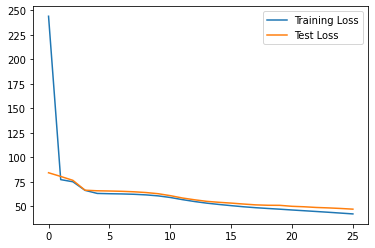

[27,     1] loss: 40.606
[27,     2] loss: 41.359
[27,     3] loss: 40.532
[27,     4] loss: 37.656
[27,     5] loss: 41.153
[27,     6] loss: 40.850
[27,     7] loss: 42.996
[27,     8] loss: 41.787
[27,     9] loss: 41.799
[27,    10] loss: 42.107
[27,    11] loss: 37.754
[27,    12] loss: 43.228
[27,    13] loss: 42.166
[27,    14] loss: 41.549
[27,    15] loss: 40.647
[27,    16] loss: 40.570
[27,    17] loss: 42.191
[27,    18] loss: 37.713
[27,    19] loss: 42.111
[27,    20] loss: 41.832
[27,    21] loss: 43.906
[27,    22] loss: 41.347
[27,    23] loss: 42.672
[27,    24] loss: 41.378
[27,    25] loss: 40.640
[27,    26] loss: 39.787
[27,    27] loss: 41.742
[27,    28] loss: 38.651
[27,    29] loss: 40.031
[27,    30] loss: 40.102
[27,    31] loss: 39.694
[27,    32] loss: 42.584
[27,    33] loss: 41.568
[27,    34] loss: 40.197
[27,    35] loss: 42.207
[27,    36] loss: 39.843
[27,    37] loss: 41.174
[27,    38] loss: 42.077
[27,    39] loss: 40.282
[27,    40] loss: 41.444


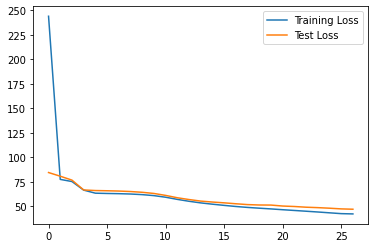

[28,     1] loss: 40.032
[28,     2] loss: 41.087
[28,     3] loss: 40.346
[28,     4] loss: 37.041
[28,     5] loss: 41.358
[28,     6] loss: 41.659
[28,     7] loss: 43.726
[28,     8] loss: 40.754
[28,     9] loss: 41.306
[28,    10] loss: 41.258
[28,    11] loss: 37.188
[28,    12] loss: 42.728
[28,    13] loss: 41.060
[28,    14] loss: 40.792
[28,    15] loss: 40.043
[28,    16] loss: 39.147
[28,    17] loss: 40.709
[28,    18] loss: 37.077
[28,    19] loss: 40.970
[28,    20] loss: 40.006
[28,    21] loss: 41.241
[28,    22] loss: 40.406
[28,    23] loss: 41.238
[28,    24] loss: 39.143
[28,    25] loss: 39.658
[28,    26] loss: 38.910
[28,    27] loss: 40.217
[28,    28] loss: 37.023
[28,    29] loss: 39.082
[28,    30] loss: 39.457
[28,    31] loss: 38.077
[28,    32] loss: 41.692
[28,    33] loss: 40.717
[28,    34] loss: 38.994
[28,    35] loss: 40.379
[28,    36] loss: 39.538
[28,    37] loss: 39.613
[28,    38] loss: 40.584
[28,    39] loss: 40.412
[28,    40] loss: 39.428


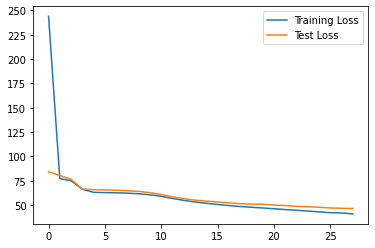

[29,     1] loss: 39.635
[29,     2] loss: 40.014
[29,     3] loss: 39.553
[29,     4] loss: 36.677
[29,     5] loss: 40.196
[29,     6] loss: 40.167
[29,     7] loss: 41.678
[29,     8] loss: 40.133
[29,     9] loss: 40.097
[29,    10] loss: 40.035
[29,    11] loss: 36.389
[29,    12] loss: 41.241
[29,    13] loss: 39.976
[29,    14] loss: 39.969
[29,    15] loss: 39.168
[29,    16] loss: 38.359
[29,    17] loss: 39.715
[29,    18] loss: 36.340
[29,    19] loss: 40.329
[29,    20] loss: 39.050
[29,    21] loss: 40.337
[29,    22] loss: 39.990
[29,    23] loss: 40.094
[29,    24] loss: 38.792
[29,    25] loss: 39.282
[29,    26] loss: 38.184
[29,    27] loss: 39.597
[29,    28] loss: 36.293
[29,    29] loss: 38.543
[29,    30] loss: 38.536
[29,    31] loss: 37.728
[29,    32] loss: 40.331
[29,    33] loss: 39.586
[29,    34] loss: 38.121
[29,    35] loss: 39.467
[29,    36] loss: 38.251
[29,    37] loss: 38.465
[29,    38] loss: 39.694
[29,    39] loss: 38.754
[29,    40] loss: 38.783


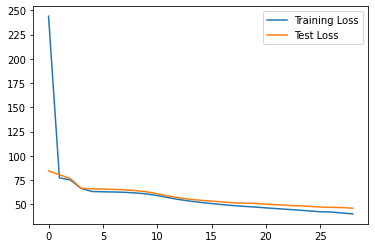

[30,     1] loss: 38.573
[30,     2] loss: 39.024
[30,     3] loss: 38.386
[30,     4] loss: 35.666
[30,     5] loss: 39.225
[30,     6] loss: 38.845
[30,     7] loss: 40.855
[30,     8] loss: 39.247
[30,     9] loss: 39.151
[30,    10] loss: 39.129
[30,    11] loss: 35.745
[30,    12] loss: 40.291
[30,    13] loss: 38.993
[30,    14] loss: 39.158
[30,    15] loss: 38.231
[30,    16] loss: 37.593
[30,    17] loss: 38.867
[30,    18] loss: 35.484
[30,    19] loss: 39.356
[30,    20] loss: 38.150
[30,    21] loss: 39.438
[30,    22] loss: 38.716
[30,    23] loss: 39.354
[30,    24] loss: 37.735
[30,    25] loss: 38.151
[30,    26] loss: 37.349
[30,    27] loss: 38.604
[30,    28] loss: 35.415
[30,    29] loss: 37.563
[30,    30] loss: 37.843
[30,    31] loss: 36.757
[30,    32] loss: 39.467
[30,    33] loss: 38.740
[30,    34] loss: 37.274
[30,    35] loss: 38.746
[30,    36] loss: 37.434
[30,    37] loss: 37.926
[30,    38] loss: 38.748
[30,    39] loss: 38.245
[30,    40] loss: 38.144


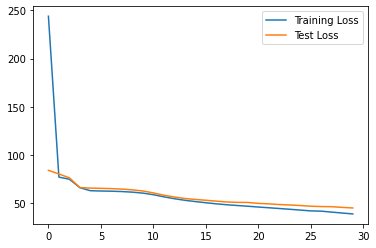

Finished Training


In [27]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)

print('Finished Training')

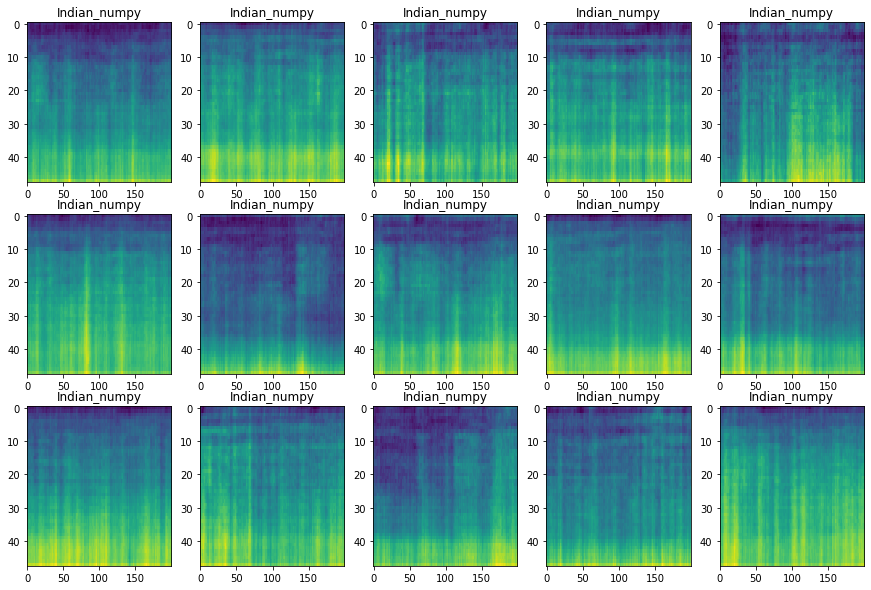

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

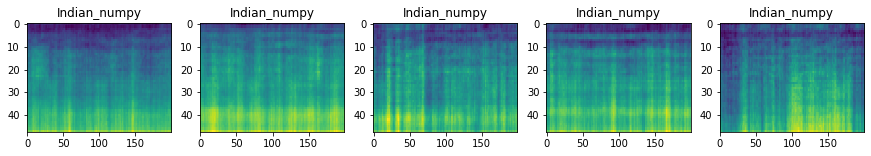

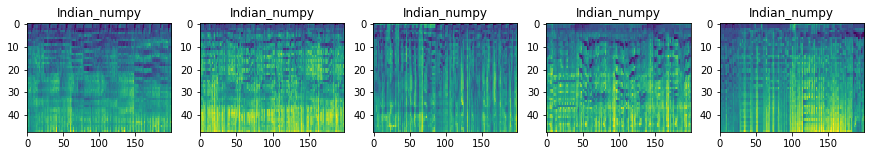

In [ ]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [ ]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [ ]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Strict data separation

In [11]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


In [ ]:
# get some random training images
dataiter = iter(trainloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
# get some random training images
dataiter = iter(testloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader_combined:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




In [ ]:
id_train = 0
with torch.no_grad():
    for data in trainloader_combined:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1